In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

## Load the training data into feature matrix, class labels, and event ids:

In [2]:
from proj1_helpers import *
DATA_TRAIN_PATH = '../data/train.csv' 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

In [3]:
from implementations import *

## Do your thing crazy machine learning thing here :) ...

In [4]:
# Separate the data according to the value of column 24 (PRI_jet_num) 

def separate(y, tX, ids):
    
    split_x = []
    split_y = []
    split_ids = []
    
    jet_column_nbr = 22
    
    for i in range(4):
        
        split_x.append(tX[np.where(tX[:,jet_column_nbr] == i)])
        split_y.append(y[np.where(tX[:,jet_column_nbr] == i)])
        split_ids.append(ids[np.where(tX[:,jet_column_nbr] == i)])
    
    
    
    return split_x, split_y, split_ids

In [5]:
split_x, split_y, split_ids = separate(y, tX, ids)

In [6]:
#remove the columns from each set of data given a boolean array

def removeNone(data, selection):
   
    cleaned=[]
    
    for i in range(4):
        curr_data = data[i]
        
        cleaned.append(curr_data[:,selection[i]])
      
    return cleaned
    
    

In [7]:
#print statistics about the None values (-999) for each columns
#returns a boolean array that can be used to filter the columns that have 100% of undefined values (-999)
def dataStatistics(data):
    
    stats=[]
    
    for i in range(4):
        
        print("Statistics ")
        print("Type :")
        print(i)
        
        
        nones = (data[i] == -999)
    
        mean = np.sum(nones, axis=0)/nones.shape[0]
        print(mean) 
        stats.append(mean != 1)
    
    return stats
    

In [8]:
selection = dataStatistics(split_x)

Statistics 
Type :
0
[0.26145747 0.         0.         0.         1.         1.
 1.         0.         0.         0.         0.         0.
 1.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         1.
 1.         1.         1.         1.         1.         0.        ]
Statistics 
Type :
1
[0.09751883 0.         0.         0.         1.         1.
 1.         0.         0.         0.         0.         0.
 1.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         1.         1.         1.         0.        ]
Statistics 
Type :
2
[0.05859584 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
Statistics 
Type :
3
[0.0

In [9]:
cleaned = removeNone(split_x, selection)



# Now we can either drop the lines with residual Nones or replace the Nones by the median value

In [10]:
#replace the value of column 0 (can be None sometimes) by the median value of this column

def putMedianInsteadOfNone(cleaned):
    
    completed_data = []
    
    for i in range(4):
        #current PRI_jet_num
        current = cleaned[i]
        
        median = np.median(current[np.where(current[:,0] != -999)], axis = 0)
        
        #replace -999 by median value
        current[np.where(current[:,0] == -999)] = median
        
        completed_data.append(current)
    
    
    return completed_data
    
    

In [11]:
cleaned_with_median = putMedianInsteadOfNone(cleaned)



In [94]:
#Instead of putting the median we can simply drop the data where columns 0 == -999
def dropLineIfNone(cleaned, split_y, split_ids):
    
    res_x=[]
    res_y=[]
    res_ids=[]
    
    for i in range(4):
        
        current = cleaned[i]
        
        drop_indexes = np.where(current[:,0] != -999)
        
        res_x.append(current[drop_indexes])
        res_y.append(current[drop_indexes])
        res_ids.append(current[drop_indexes])
        
    return res_x, res_y, res_ids

In [13]:
dropped_x, dropped_y, dropped_ids = dropLineIfNone(cleaned, split_y, split_ids)


## At this point, the first values in each of the split data has a PRI_jet_num = 0, then 1 and so on. The data is clean and we can work with it.

In [14]:
initial_w = np.zeros(cleaned_with_median[0].shape[1])
median_cleaned_x_0_lsq_GD = least_squares_GD(split_y[0], normalize(cleaned_with_median[0]), initial_w, 500, 0.1)

In [15]:
print(median_cleaned_x_0_lsq_GD)

(array([ 0.2155689 , -0.53554557, -0.40401874,  0.03959931,  0.08147027,
        0.03959934,  0.16148251,  0.03462872,  0.10957412,  0.5842968 ,
        0.05218412,  0.04930115, -0.04715568,  0.05726908,  0.0508691 ,
       -0.07238437,  0.03803752, -0.00064042,  0.05024209,  0.05024209]), 0.29714565802617193)


In [16]:
median_cleaned_x_0_lsq_SGD = least_squares_SGD(split_y[0], normalize(cleaned_with_median[0]), initial_w, 500, 0.001)

In [17]:
print(median_cleaned_x_0_lsq_SGD)

(array([-0.03415192, -0.10838841, -0.02479375,  0.022209  ,  0.02761712,
        0.022209  , -0.01267088,  0.02689357,  0.0322059 ,  0.0434371 ,
        0.02972195,  0.03074625, -0.02174099,  0.03006534,  0.02920467,
       -0.01581236,  0.03042716, -0.05358197,  0.02996181,  0.02996181]), 0.36323275355184187)


In [36]:
median_cleaned_x_0_lsq = least_squares(split_y[0], normalize(cleaned_with_median[0]))

In [37]:
print(median_cleaned_x_0_lsq)

(array([ 1.19348795e-01, -3.20910721e-01, -7.11010650e-01, -3.62337265e+03,
        2.92434116e+01,  3.62345882e+03, -7.97192057e+00, -1.48451089e+01,
       -9.21399478e-01,  8.74154019e+00,  1.22203119e-02,  9.00427055e-03,
        8.51383345e+00,  1.42330453e-01,  1.82845411e-02, -8.31033254e-02,
       -1.72379530e-01,  3.24837923e-02, -9.72705128e+00, -9.72705128e+00]), 0.2599109628358987)


In [20]:
median_cleaned_x_0_ridge = ridge_regression(split_y[0], normalize(cleaned_with_median[0]), 0.037)

In [181]:
print(median_cleaned_x_0_ridge)

NameError: name 'median_cleaned_x_0_ridge' is not defined

In [180]:
median_cleaned_x_0_log = logistic_regression(split_y[0], normalize(cleaned_with_median[0]), initial_w, 10000, 0.01)

NameError: name 'logistic_regression' is not defined

In [ ]:
print(median_cleaned_x_0_log)

## Cross Validation

In [12]:
#method to split the training set into a (new) training set and a test set (same as in lab03)

def split_data(x, y, ratio, seed=1):
    """
    split the dataset based on the split ratio. If ratio is 0.8 
    you will have 80% of your data set dedicated to training 
    and the rest dedicated to testing
    """
    # set seed
    np.random.seed(seed)
 
    # split the data based on the given ratio

    training_nbr = int(x.shape[0] * ratio)
    indexes = np.random.choice(x.shape[0],training_nbr, replace=False)
    
    x_train = x[indexes]
    y_train = y[indexes]
    x_test = np.delete(x, indexes, axis = 0)
    y_test = np.delete(y, indexes, axis = 0)
    
    
    return x_train, y_train, x_test, y_test

In [92]:
#perform cross-validation 

def crossValidation(x, y, splitRatio, seed =1):
    
    x_train, y_train, x_test, y_test = split_data(x, y, splitRatio, seed)
    
    a_training = []
    a_testing = []
    weights = []
    
    #normalize data (DANGER: the test set must be normalized with the training set's mean and std)
    mean = np.mean(x_train)
    std = np.std(x_train)
    
    x_train = (x_train - mean) / std
    x_test = (x_test - mean) / std
    
    # define parameter (just add more for loops if there are more parameters for the model)
    lambdas = np.arange(0,0.03,0.0001)
    
    for ind, lambda_ in enumerate(lambdas):
        
        #train model with these parameters and compute the error (MSE or RMSE)
        
        #ideal : lambdas = np.arange(0,0.03,0.0001)
        w_star, e_tr = ridge_regression(y_train,x_train, lambda_)
        
        #ideal : lambdas = np.arange(0,0.3,0.1)
        #w_star, e_tr = logistic_regression(y_train, x_train,np.ones(x_train.shape[1])  ,400, lambda_)
        
        #don't usel least squares with lambda bigger than 0.35 ideal: lambdas = np.arange(0.001,0.13,0.01)
        #w_star, e_tr = least_squares_GD(y_train, x_train,np.ones(x_train.shape[1])  ,400, lambda_)    
        #w_star, e_tr = least_squares_SGD(y_train, x_train,np.ones(x_train.shape[1])  ,400, lambda_)
        
        #DON'T REALLY NEED TO DO CROSS VALIDATION FOR THIS ONE ;) BUT PRACTICAL TO RUN IT HERE
        #w_star, e_tr = least_squares(y_train, x_train)  
        
        #compare the prediction with the reality
        accuracy_training = np.count_nonzero(predict_labels(w_star, x_train) + y_train)/len(y_train)
        accuracy_testing = np.count_nonzero(predict_labels(w_star, x_test) + y_test)/len(y_test)
        
        a_training.append(accuracy_training)
        a_testing.append(accuracy_testing)
        weights.append(w_star)
        print("lambda={l:.3f}, Training Accuracy={tr}, Testing Accuracy={te}".format(
               l=lambda_, tr=a_training[ind], te=a_testing[ind]))
        
    plt.plot(lambdas, a_training,'r--' , lambdas, a_testing, 'g--')
    plt.show
    
    return weights[np.argmax(a_testing)], a_testing[np.argmax(a_testing)]

lambda=0.000, Training Accuracy=0.8244570233871954, Testing Accuracy=0.8282626100880705
lambda=0.000, Training Accuracy=0.8089100432601951, Testing Accuracy=0.8145516413130505
lambda=0.000, Training Accuracy=0.806552418233783, Testing Accuracy=0.8125500400320256
lambda=0.000, Training Accuracy=0.8054959353210039, Testing Accuracy=0.8109487590072058
lambda=0.000, Training Accuracy=0.804784199463974, Testing Accuracy=0.8112489991993594
lambda=0.001, Training Accuracy=0.8042948810622658, Testing Accuracy=0.8111489191353083
lambda=0.001, Training Accuracy=0.8041280679707743, Testing Accuracy=0.8105484387510008
lambda=0.001, Training Accuracy=0.8039834966248152, Testing Accuracy=0.8108486789431545
lambda=0.001, Training Accuracy=0.8036832330601306, Testing Accuracy=0.8109487590072058
lambda=0.001, Training Accuracy=0.803494178223107, Testing Accuracy=0.8108486789431545
lambda=0.001, Training Accuracy=0.8033940903682121, Testing Accuracy=0.8109487590072058
lambda=0.001, Training Accuracy=0.8

lambda=0.011, Training Accuracy=0.7986009942060253, Testing Accuracy=0.8049439551641313
lambda=0.011, Training Accuracy=0.798567631587727, Testing Accuracy=0.80484387510008
lambda=0.011, Training Accuracy=0.7985120272238966, Testing Accuracy=0.8046437149719776
lambda=0.011, Training Accuracy=0.7984453019873, Testing Accuracy=0.8045436349079264
lambda=0.011, Training Accuracy=0.7984008184962356, Testing Accuracy=0.8045436349079264
lambda=0.011, Training Accuracy=0.7983674558779373, Testing Accuracy=0.8045436349079264
lambda=0.011, Training Accuracy=0.7983118515141068, Testing Accuracy=0.8045436349079264
lambda=0.012, Training Accuracy=0.7982784888958085, Testing Accuracy=0.8045436349079264
lambda=0.012, Training Accuracy=0.7982006427864459, Testing Accuracy=0.8045436349079264
lambda=0.012, Training Accuracy=0.798211763659212, Testing Accuracy=0.8045436349079264
lambda=0.012, Training Accuracy=0.7981450384226154, Testing Accuracy=0.8045436349079264
lambda=0.012, Training Accuracy=0.79813

lambda=0.021, Training Accuracy=0.7948643809566175, Testing Accuracy=0.8017413931144916
lambda=0.021, Training Accuracy=0.7948310183383192, Testing Accuracy=0.8017413931144916
lambda=0.021, Training Accuracy=0.7947976557200209, Testing Accuracy=0.8015412329863891
lambda=0.021, Training Accuracy=0.7947309304834244, Testing Accuracy=0.8013410728582866
lambda=0.022, Training Accuracy=0.7946864469923599, Testing Accuracy=0.8013410728582866
lambda=0.022, Training Accuracy=0.7946419635012956, Testing Accuracy=0.8014411529223379
lambda=0.022, Training Accuracy=0.7946642052468278, Testing Accuracy=0.8014411529223379
lambda=0.022, Training Accuracy=0.7946642052468278, Testing Accuracy=0.8014411529223379
lambda=0.022, Training Accuracy=0.7946642052468278, Testing Accuracy=0.8015412329863891
lambda=0.022, Training Accuracy=0.7946197217557633, Testing Accuracy=0.8014411529223379
lambda=0.022, Training Accuracy=0.7944862712825702, Testing Accuracy=0.8012409927942354
lambda=0.022, Training Accuracy=

(0.0,
 array([ 1.16496703e-01, -3.32022720e-01, -7.02323301e-01, -2.58364295e+03,
         2.90250927e+01,  2.58372100e+03, -7.96694075e+00, -1.49032867e+01,
        -9.17745403e-01,  8.71658689e+00,  2.80986232e-03,  3.37495184e-02,
         8.52302851e+00,  1.30113359e-01,  3.23194784e-03, -6.94646766e-02,
        -1.72429854e-01,  3.33841984e-02, -9.59010426e+00, -9.59010426e+00]),
 0.8282626100880705)

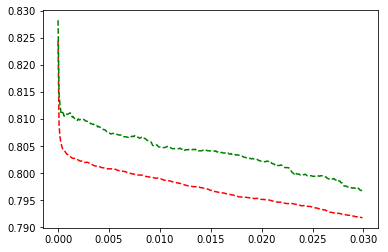

In [89]:
crossValidation(cleaned_with_median[0], split_y[0], 0.9, 6)

## Generate predictions and save ouput in csv format for submission:

In [103]:
DATA_TEST_PATH = '../data/test.csv' 
y_donotUse, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

Statistics 
Type :
0
[0.2605448 0.        0.        0.        1.        1.        1.
 0.        0.        0.        0.        0.        1.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        1.        1.        1.        1.        1.
 1.        0.       ]
Statistics 
Type :
1
[0.09834149 0.         0.         0.         1.         1.
 1.         0.         0.         0.         0.         0.
 1.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         1.         1.         1.         0.        ]
Statistics 
Type :
2
[0.05881481 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
Statistics 
Type :
3
[0.06376737 0.         0.     

lambda=0.009, Training Accuracy=0.7994684222817807, Testing Accuracy=0.8064451561248999
lambda=0.009, Training Accuracy=0.7994239387907163, Testing Accuracy=0.8063450760608487
lambda=0.009, Training Accuracy=0.799390576172418, Testing Accuracy=0.8061449159327462
lambda=0.009, Training Accuracy=0.7993572135541197, Testing Accuracy=0.8060448358686949
lambda=0.009, Training Accuracy=0.7993349718085876, Testing Accuracy=0.8060448358686949
lambda=0.009, Training Accuracy=0.7992904883175231, Testing Accuracy=0.8059447558046438
lambda=0.009, Training Accuracy=0.7993349718085876, Testing Accuracy=0.8058446757405925
lambda=0.009, Training Accuracy=0.7992571256992249, Testing Accuracy=0.8055444355484388
lambda=0.009, Training Accuracy=0.7992237630809266, Testing Accuracy=0.8051441152922338
lambda=0.009, Training Accuracy=0.79915703784433, Testing Accuracy=0.8050440352281826
lambda=0.009, Training Accuracy=0.7991347960987978, Testing Accuracy=0.8050440352281826
lambda=0.010, Training Accuracy=0.7

lambda=0.020, Training Accuracy=0.7953314576127934, Testing Accuracy=0.802341873498799
lambda=0.020, Training Accuracy=0.7952202488851325, Testing Accuracy=0.8022417934347478
lambda=0.020, Training Accuracy=0.795164644521302, Testing Accuracy=0.8022417934347478
lambda=0.020, Training Accuracy=0.795164644521302, Testing Accuracy=0.8021417133706965
lambda=0.020, Training Accuracy=0.795164644521302, Testing Accuracy=0.8021417133706965
lambda=0.020, Training Accuracy=0.7951424027757699, Testing Accuracy=0.8021417133706965
lambda=0.020, Training Accuracy=0.7950979192847054, Testing Accuracy=0.8021417133706965
lambda=0.021, Training Accuracy=0.7950756775391733, Testing Accuracy=0.8022417934347478
lambda=0.021, Training Accuracy=0.7950756775391733, Testing Accuracy=0.8022417934347478
lambda=0.021, Training Accuracy=0.7950534357936411, Testing Accuracy=0.8021417133706965
lambda=0.021, Training Accuracy=0.7950311940481088, Testing Accuracy=0.8019415532425941
lambda=0.021, Training Accuracy=0.79

lambda=0.000, Training Accuracy=0.7018727879751824, Testing Accuracy=0.6977433913604126
lambda=0.000, Training Accuracy=0.7013712762756308, Testing Accuracy=0.6981302385557705
lambda=0.001, Training Accuracy=0.7005831864620499, Testing Accuracy=0.6986460348162475
lambda=0.001, Training Accuracy=0.7001676481967072, Testing Accuracy=0.6990328820116054
lambda=0.001, Training Accuracy=0.6997234521199616, Testing Accuracy=0.6980012894906512
lambda=0.001, Training Accuracy=0.6995371763458424, Testing Accuracy=0.6978723404255319
lambda=0.001, Training Accuracy=0.6990929802690968, Testing Accuracy=0.6983881366860091
lambda=0.001, Training Accuracy=0.6989210334006792, Testing Accuracy=0.6983881366860091
lambda=0.001, Training Accuracy=0.6987490865322615, Testing Accuracy=0.6973565441650548
lambda=0.001, Training Accuracy=0.6985054951353366, Testing Accuracy=0.6973565441650548
lambda=0.001, Training Accuracy=0.6984481795125306, Testing Accuracy=0.6967117988394584
lambda=0.001, Training Accuracy=

lambda=0.013, Training Accuracy=0.6884752611443065, Testing Accuracy=0.6861379754996776
lambda=0.013, Training Accuracy=0.6884036166157991, Testing Accuracy=0.6860090264345583
lambda=0.013, Training Accuracy=0.6883463009929932, Testing Accuracy=0.6858800773694391
lambda=0.013, Training Accuracy=0.6882459986530829, Testing Accuracy=0.6856221792392005
lambda=0.013, Training Accuracy=0.6882316697473814, Testing Accuracy=0.6854932301740813
lambda=0.013, Training Accuracy=0.6882030119359784, Testing Accuracy=0.685364281108962
lambda=0.013, Training Accuracy=0.688188683030277, Testing Accuracy=0.6852353320438427
lambda=0.013, Training Accuracy=0.6880883806903667, Testing Accuracy=0.6849774339136041
lambda=0.013, Training Accuracy=0.6879594205390535, Testing Accuracy=0.6851063829787234
lambda=0.013, Training Accuracy=0.6879450916333519, Testing Accuracy=0.6851063829787234
lambda=0.014, Training Accuracy=0.6877158291421284, Testing Accuracy=0.6852353320438427
lambda=0.014, Training Accuracy=0.

lambda=0.025, Training Accuracy=0.6802361403659603, Testing Accuracy=0.6773694390715668
lambda=0.025, Training Accuracy=0.6802361403659603, Testing Accuracy=0.6773694390715668
lambda=0.025, Training Accuracy=0.6801788247431544, Testing Accuracy=0.6773694390715668
lambda=0.025, Training Accuracy=0.680107180214647, Testing Accuracy=0.6773694390715668
lambda=0.025, Training Accuracy=0.6800212067804382, Testing Accuracy=0.6773694390715668
lambda=0.025, Training Accuracy=0.6799782200633337, Testing Accuracy=0.6768536428110896
lambda=0.026, Training Accuracy=0.6799925489690353, Testing Accuracy=0.676595744680851
lambda=0.026, Training Accuracy=0.6799782200633337, Testing Accuracy=0.676595744680851
lambda=0.026, Training Accuracy=0.6799352333462293, Testing Accuracy=0.6764667956157318
lambda=0.026, Training Accuracy=0.6797919442892146, Testing Accuracy=0.676595744680851
lambda=0.026, Training Accuracy=0.6797202997607072, Testing Accuracy=0.676595744680851
lambda=0.026, Training Accuracy=0.679

lambda=0.007, Training Accuracy=0.7100857943141968, Testing Accuracy=0.6982929734021437
lambda=0.007, Training Accuracy=0.7099975739397014, Testing Accuracy=0.6984914648670107
lambda=0.007, Training Accuracy=0.7101078494078208, Testing Accuracy=0.6978959904724097
lambda=0.008, Training Accuracy=0.709887298471582, Testing Accuracy=0.6978959904724097
lambda=0.008, Training Accuracy=0.7098431882843342, Testing Accuracy=0.6980944819372767
lambda=0.008, Training Accuracy=0.7098652433779581, Testing Accuracy=0.6978959904724097
lambda=0.008, Training Accuracy=0.7097329128162149, Testing Accuracy=0.6969035331480746
lambda=0.008, Training Accuracy=0.7097549679098388, Testing Accuracy=0.6971020246129417
lambda=0.008, Training Accuracy=0.709710857722591, Testing Accuracy=0.6967050416832076
lambda=0.008, Training Accuracy=0.7096888026289672, Testing Accuracy=0.6967050416832076
lambda=0.008, Training Accuracy=0.7097329128162149, Testing Accuracy=0.6963080587534736
lambda=0.008, Training Accuracy=0.

lambda=0.018, Training Accuracy=0.704704351469972, Testing Accuracy=0.6889638745533943
lambda=0.018, Training Accuracy=0.7047264065635959, Testing Accuracy=0.6889638745533943
lambda=0.018, Training Accuracy=0.7046381861891003, Testing Accuracy=0.6889638745533943
lambda=0.018, Training Accuracy=0.7046602412827242, Testing Accuracy=0.6889638745533943
lambda=0.018, Training Accuracy=0.7046161310954765, Testing Accuracy=0.6881699086939261
lambda=0.018, Training Accuracy=0.704527910720981, Testing Accuracy=0.6879714172290592
lambda=0.018, Training Accuracy=0.7044617454401094, Testing Accuracy=0.6883684001587932
lambda=0.018, Training Accuracy=0.7044617454401094, Testing Accuracy=0.6877729257641921
lambda=0.019, Training Accuracy=0.70435146997199, Testing Accuracy=0.6875744342993251
lambda=0.019, Training Accuracy=0.7042632495974945, Testing Accuracy=0.6877729257641921
lambda=0.019, Training Accuracy=0.704175029222999, Testing Accuracy=0.6879714172290592
lambda=0.019, Training Accuracy=0.704

lambda=0.028, Training Accuracy=0.6993890739066188, Testing Accuracy=0.685391028185788
lambda=0.028, Training Accuracy=0.6994772942811143, Testing Accuracy=0.685391028185788
lambda=0.029, Training Accuracy=0.6994331840938665, Testing Accuracy=0.6855895196506551
lambda=0.029, Training Accuracy=0.6994993493747381, Testing Accuracy=0.685391028185788
lambda=0.029, Training Accuracy=0.6994993493747381, Testing Accuracy=0.685391028185788
lambda=0.029, Training Accuracy=0.6996096248428575, Testing Accuracy=0.685192536720921
lambda=0.029, Training Accuracy=0.6995875697492336, Testing Accuracy=0.685192536720921
lambda=0.029, Training Accuracy=0.6995655146556097, Testing Accuracy=0.684994045256054
lambda=0.029, Training Accuracy=0.699521404468362, Testing Accuracy=0.685192536720921
lambda=0.029, Training Accuracy=0.6995655146556097, Testing Accuracy=0.685192536720921
lambda=0.029, Training Accuracy=0.6995655146556097, Testing Accuracy=0.684994045256054
lambda=0.029, Training Accuracy=0.699455239

lambda=0.011, Training Accuracy=0.7161979244999248, Testing Accuracy=0.731168245376635
lambda=0.011, Training Accuracy=0.7162480573519827, Testing Accuracy=0.7320703653585927
lambda=0.011, Training Accuracy=0.7162981902040407, Testing Accuracy=0.7325214253495715
lambda=0.011, Training Accuracy=0.7162480573519827, Testing Accuracy=0.7325214253495715
lambda=0.011, Training Accuracy=0.7162480573519827, Testing Accuracy=0.7325214253495715
lambda=0.011, Training Accuracy=0.7163984559081567, Testing Accuracy=0.7325214253495715
lambda=0.012, Training Accuracy=0.7164485887602146, Testing Accuracy=0.7325214253495715
lambda=0.012, Training Accuracy=0.7164485887602146, Testing Accuracy=0.7325214253495715
lambda=0.012, Training Accuracy=0.7163984559081567, Testing Accuracy=0.7325214253495715
lambda=0.012, Training Accuracy=0.7163984559081567, Testing Accuracy=0.7325214253495715
lambda=0.012, Training Accuracy=0.7163483230560986, Testing Accuracy=0.7325214253495715
lambda=0.012, Training Accuracy=0

lambda=0.026, Training Accuracy=0.7151952674587657, Testing Accuracy=0.7329724853405503
lambda=0.026, Training Accuracy=0.7152454003108237, Testing Accuracy=0.7325214253495715
lambda=0.026, Training Accuracy=0.7152454003108237, Testing Accuracy=0.7325214253495715
lambda=0.026, Training Accuracy=0.7152454003108237, Testing Accuracy=0.7325214253495715
lambda=0.027, Training Accuracy=0.7152454003108237, Testing Accuracy=0.7325214253495715
lambda=0.027, Training Accuracy=0.7152454003108237, Testing Accuracy=0.7325214253495715
lambda=0.027, Training Accuracy=0.7151952674587657, Testing Accuracy=0.7325214253495715
lambda=0.027, Training Accuracy=0.7151952674587657, Testing Accuracy=0.7325214253495715
lambda=0.027, Training Accuracy=0.7151952674587657, Testing Accuracy=0.7320703653585927
lambda=0.027, Training Accuracy=0.7151451346067078, Testing Accuracy=0.7320703653585927
lambda=0.027, Training Accuracy=0.7151451346067078, Testing Accuracy=0.7320703653585927
lambda=0.027, Training Accuracy=

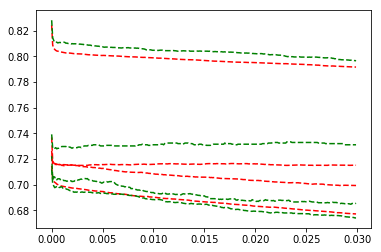

In [105]:
#separate data with respect to column 24 and remove None
split_x_test, _, split_ids_test =  separate(y_donotUse, tX_test, ids_test)
split_x_cleaned_test = removeNone(split_x, dataStatistics(split_x_test))

#median instead of None
split_x_with_median = putMedianInsteadOfNone(split_x_cleaned_test)

#line dropped when None
#split_x_drop_lines, split_y_dropped_split_indexes_dropped = dropLineIfNone(split_x_cleaned_test, _, split_ids_test)

y_res = []

for i in range(4):
    w_star, accuracy = crossValidation(cleaned_with_median[i], split_y[i], 0.9, 6)
    
    y_res.append(predict_labels(w_star, normalize(split_x_with_median[i])))





In [3]:
OUTPUT_PATH = '../data/submission.csv'
#y_pred = predict_labels(weights, tX_test)

y_pred = putTogether(y_res, split_ids_test)

create_csv_submission(ids_test, y_pred, OUTPUT_PATH)

NameError: name 'weights' is not defined